# Objective
A store in Ohio needs a model to predict the future sales of a particular product


### Importing relevant libraries

In [1]:
import warnings

warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

##Import the requred libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py

import datetime as dt

from sklearn import metrics

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot

py.init_notebook_mode()
%matplotlib inline
import seaborn as sns
from pylab import rcParams

%load_ext nb_black
rcParams["figure.figsize"] = 15, 8

<IPython.core.display.Javascript object>

### Read in Data and Process Dates

In [2]:
df = pd.read_csv("dataset.csv")

<IPython.core.display.Javascript object>

In [3]:
# cheking the first 5 row of data
df.head()

Time Date  Product          Store     Value
0    1012018  2667437  QLD_CW_ST0203  2926.000
1    2012018  2667437  QLD_CW_ST0203  2687.531
2    3012018  2667437  QLD_CW_ST0203  2793.000
3    4012018  2667437  QLD_CW_ST0203  2394.000
4    5012018  2667437  QLD_CW_ST0203  2660.000

<IPython.core.display.Javascript object>

In [4]:
# cheking shape of data
print(
    "There are {} rows and {} columns in the dataset".format(df.shape[0], df.shape[1])
)

There are 1080 rows and 4 columns in the dataset


<IPython.core.display.Javascript object>

In [5]:
# missing value check
df.isna().sum().any()

False

<IPython.core.display.Javascript object>

- There are no missing values in data

In [6]:
# cheking for duplicate values
df.duplicated().sum().any()

False

<IPython.core.display.Javascript object>

- There are no duplicate rows

In [7]:
# Checking for unique values in the product and stores column
print("unique values in product coulumn", df["Product"].unique(), sep="\n")
print(" ")
print("unique values in Store coulumn", df["Store"].unique(), sep="\n")

unique values in product coulumn
[2667437]
 
unique values in Store coulumn
['QLD_CW_ST0203']


<IPython.core.display.Javascript object>

- this implies that the data is about sales od a particular product in one store.

In [8]:
# Checking the data types of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time Date  1080 non-null   int64  
 1   Product    1080 non-null   int64  
 2   Store      1080 non-null   object 
 3   Value      1080 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 33.9+ KB


<IPython.core.display.Javascript object>

- The "Time date" column has the wrong data type(int)

In [9]:
# descriptive statistic of my data
df.describe()

Time Date    Product        Value
count  1.080000e+03     1080.0  1080.000000
mean   1.567207e+07  2667437.0  4048.117478
std    8.791548e+06        0.0  1439.945783
min    1.012018e+06  2667437.0  2042.813500
25%    8.069518e+06  2667437.0  2632.498599
50%    1.556702e+07  2667437.0  4256.000000
75%    2.308452e+07  2667437.0  5288.248910
max    3.112202e+07  2667437.0  8147.739600

<IPython.core.display.Javascript object>

- The average sales is \$4048.11

## Feature Engineering

In [10]:
# Creating a date range for the index
date = pd.date_range(start="1-1-2018", periods=len(df), freq="D")

<IPython.core.display.Javascript object>

In [11]:
date

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2020-12-06', '2020-12-07', '2020-12-08', '2020-12-09',
               '2020-12-10', '2020-12-11', '2020-12-12', '2020-12-13',
               '2020-12-14', '2020-12-15'],
              dtype='datetime64[ns]', length=1080, freq='D')

<IPython.core.display.Javascript object>

In [12]:
df["Time_Stamp"] = date

<IPython.core.display.Javascript object>

In [13]:
df.head()

Time Date  Product          Store     Value Time_Stamp
0    1012018  2667437  QLD_CW_ST0203  2926.000 2018-01-01
1    2012018  2667437  QLD_CW_ST0203  2687.531 2018-01-02
2    3012018  2667437  QLD_CW_ST0203  2793.000 2018-01-03
3    4012018  2667437  QLD_CW_ST0203  2394.000 2018-01-04
4    5012018  2667437  QLD_CW_ST0203  2660.000 2018-01-05

<IPython.core.display.Javascript object>

In [14]:
df["Time_Stamp"].dtype

dtype('<M8[ns]')

<IPython.core.display.Javascript object>

In [15]:
# dropping the irrelevant columns before analysis
df.drop(['Time Date', 'Product', 'Store'], axis=1, inplace=True)


<IPython.core.display.Javascript object>

In [16]:
# Setting the time_stamp as index
df.set_index("Time_Stamp", inplace=True)
df.head()

Value
Time_Stamp          
2018-01-01  2926.000
2018-01-02  2687.531
2018-01-03  2793.000
2018-01-04  2394.000
2018-01-05  2660.000

<IPython.core.display.Javascript object>

In [17]:
# Creating vital columns for visualization
df["Year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["day_name"] = df.index.day_name()

<IPython.core.display.Javascript object>

In [18]:
df.head()

Value  Year  month  day   day_name
Time_Stamp                                       
2018-01-01  2926.000  2018      1    1     Monday
2018-01-02  2687.531  2018      1    2    Tuesday
2018-01-03  2793.000  2018      1    3  Wednesday
2018-01-04  2394.000  2018      1    4   Thursday
2018-01-05  2660.000  2018      1    5     Friday

<IPython.core.display.Javascript object>

In [19]:
df.rename(columns={"Value": "Sales"}, inplace=True)

<IPython.core.display.Javascript object>

In [20]:
df_sales = df[["Sales"]]

<IPython.core.display.Javascript object>

In [21]:
df_sales.head()

Sales
Time_Stamp          
2018-01-01  2926.000
2018-01-02  2687.531
2018-01-03  2793.000
2018-01-04  2394.000
2018-01-05  2660.000

<IPython.core.display.Javascript object>

## Data Visualization

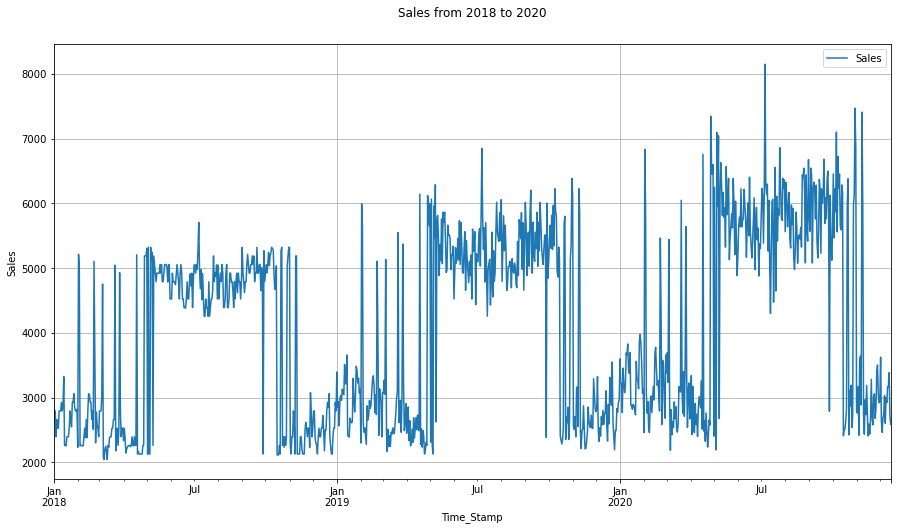

<IPython.core.display.Javascript object>

In [22]:
# Plotting a line plot of the data
df_sales.plot()
plt.title("Sales from 2018 to 2020", y=1.05)
plt.ylabel("Sales")
plt.grid()
plt.show()

- There seems to be a pattern and seaseonality in the data.
- futher analysis will be done to determine the stationarity of the data

### Yearly Plot

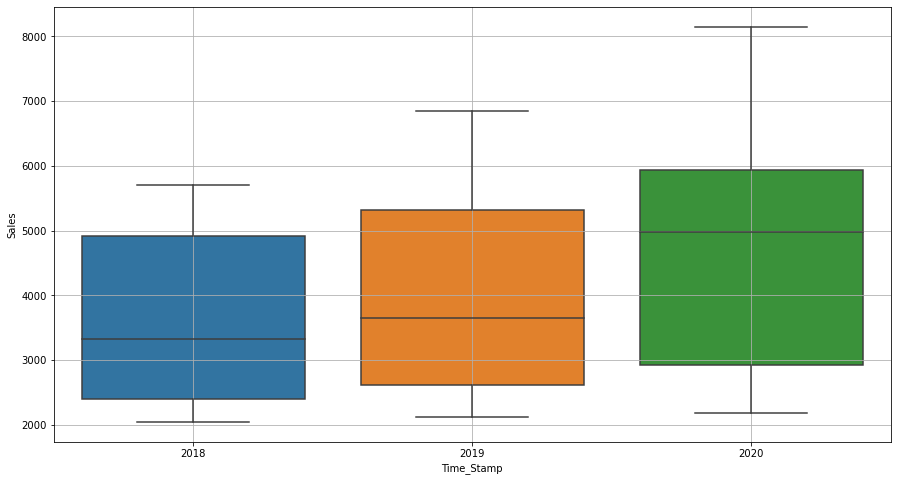

<IPython.core.display.Javascript object>

In [23]:
# Yearly BoxPlot
sns.boxplot(df_sales.index.year, df["Sales"])
plt.grid()
plt.show()

- The sales seems to be increasing by the year.

### Monthly Plot

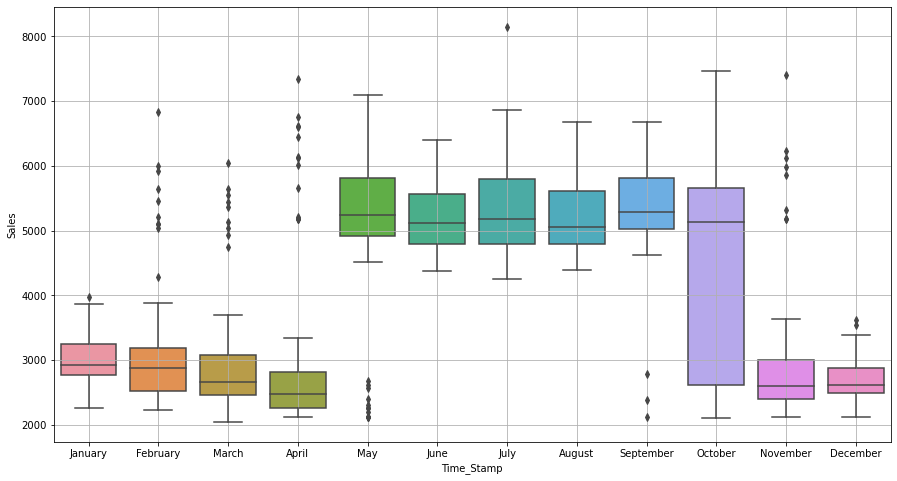

<IPython.core.display.Javascript object>

In [24]:
# Monthly BoxPlot
sns.boxplot(df_sales.index.month_name(), df["Sales"])
plt.grid()
plt.show()

- The first 4 months of each year has low sales
- The sales increases between May and September and starts dropping from October till May of the next year.

### Daily Plot

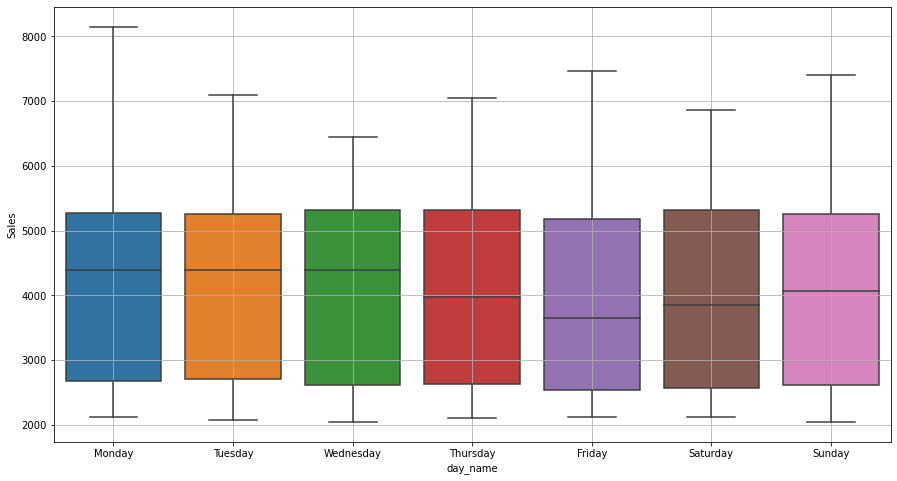

<IPython.core.display.Javascript object>

In [25]:
# Daily BoxPlot
sns.boxplot(data=df, x="day_name", y="Sales")
plt.grid()
plt.show()

- more sales are made on mondays and the least sales on Friday

### Plotting a graph of monthly RetailSales across years

In [26]:
### making a pivot table to plot the monthly plot
yearly_sales_across_months = pd.pivot_table(
    df_sales, values="Sales", columns=df_sales.index.month, index=df_sales.index.year
)

yearly_sales_across_months

Time_Stamp           1            2            3            4            5   \
Time_Stamp                                                                    
2018        2692.217748  2862.828325  2677.371945  2637.995150  4634.466945   
2019        2999.791918  3124.682098  2945.520341  2921.494629  5095.479778   
2020        3288.919751  3401.888661  3184.562404  3376.209249  5508.497267   

Time_Stamp           6            7            8            9            10  \
Time_Stamp                                                                    
2018        4707.181220  4746.463242  4726.302587  4886.251533  4084.449735   
2019        5142.498129  5295.900743  5184.909532  5345.142604  4447.598753   
2020        5630.728380  5888.605452  5745.728430  5829.976096  4960.427012   

Time_Stamp           11           12  
Time_Stamp                            
2018        2664.366390  2516.546629  
2019        2967.208139  2739.786927  
2020        3149.174919  2909.670573

<IPython.core.display.Javascript object>

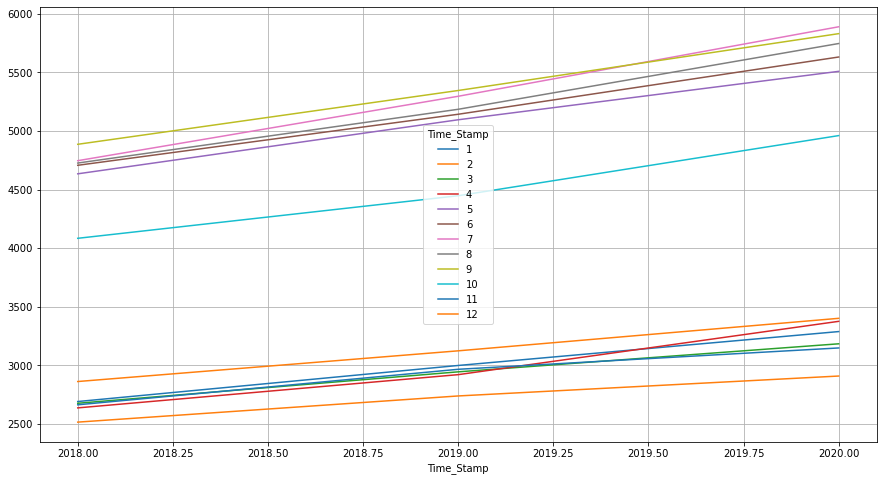

<IPython.core.display.Javascript object>

In [27]:
# yearly Sales accross months
yearly_sales_across_months.plot()
plt.grid()
plt.show()

### Monthly Plot

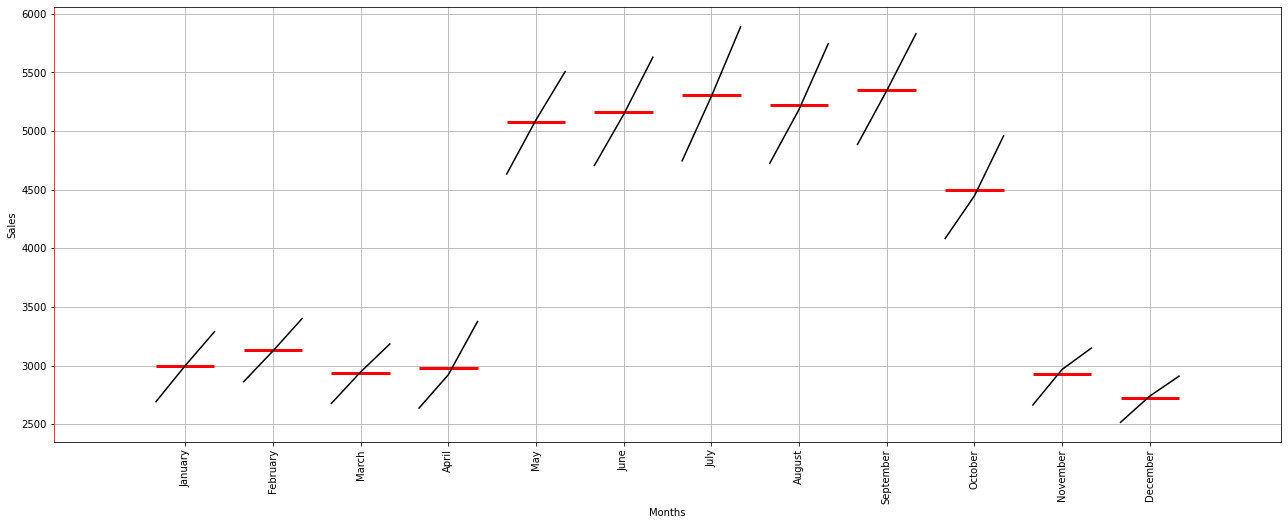

<IPython.core.display.Javascript object>

In [28]:
# Converting the daily data to monthly data for plots
df_sales_month = df_sales.resample("m").mean()

# MONTHLY PLOT
from statsmodels.graphics.tsaplots import month_plot

month_name = df_sales_month.index.month_name().unique().tolist()

fig, ax = plt.subplots(figsize=(22, 8))

month_plot(df_sales_month, ylabel="Sales", ax=ax)
ax.spines["left"].set_color("red") and ax.spines["top"]
plt.xlabel("Months")
ax.set_xticklabels(month_name, rotation=90)
plt.grid()

- More sales are done for this particular product in the middle of the year. (i.e, between May and September)

### Plot the Empirical Cumulative Distribution.

Text(0.5, 0, 'Sales')

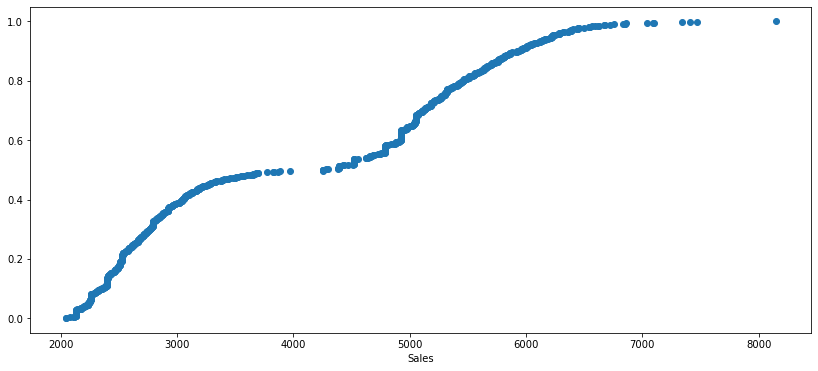

<IPython.core.display.Javascript object>

In [29]:
# Plot the Empirical Cumulative Distribution.

from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize=(14, 6))
cdf = ECDF(df_sales["Sales"])
plt.plot(cdf.x, cdf.y, label="statmodels", linestyle="", marker="o")
# plt.grid()
plt.xlabel("Sales")

- 50% of the sales are below $4256.

### Plotting the average Sales per month and the month on month percentage change of Sales.

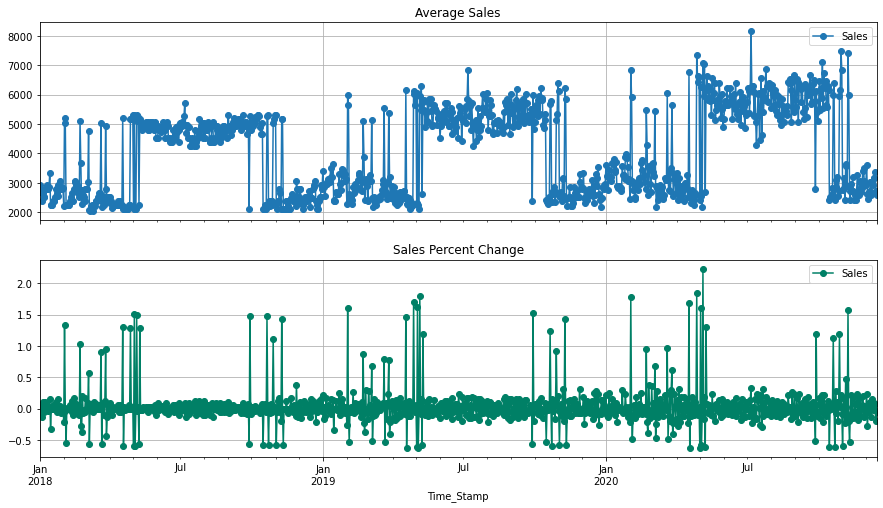

<IPython.core.display.Javascript object>

In [30]:
# group by date and get average RetailSales, and precent change
average = df.groupby(df_sales.index)["Sales"].mean()
pct_change = df.groupby(df_sales.index)["Sales"].sum().pct_change()

fig, (axis1, axis2) = plt.subplots(2, 1, sharex=True, figsize=(15, 8))

# plot average RetailSales over time(year-month)
ax1 = average.plot(legend=True, ax=axis1, marker="o", title="Average Sales", grid=True)
ax1.set_xticks(range(len(average)))
ax1.set_xticklabels(average.index.tolist())
# plot precent change for RetailSales over time(year-month)
ax2 = pct_change.plot(
    legend=True,
    ax=axis2,
    marker="o",
    colormap="summer",
    title="Sales Percent Change",
    grid=True,
)

# Split the data into train and test and plot the training and test data.

In [31]:
train = df_sales[0 : int(len(df) * 0.85)]
test = df_sales[int(len(df) * 0.85) :]

<IPython.core.display.Javascript object>

In [32]:
print(train.shape)
print(test.shape)

(918, 1)
(162, 1)


<IPython.core.display.Javascript object>

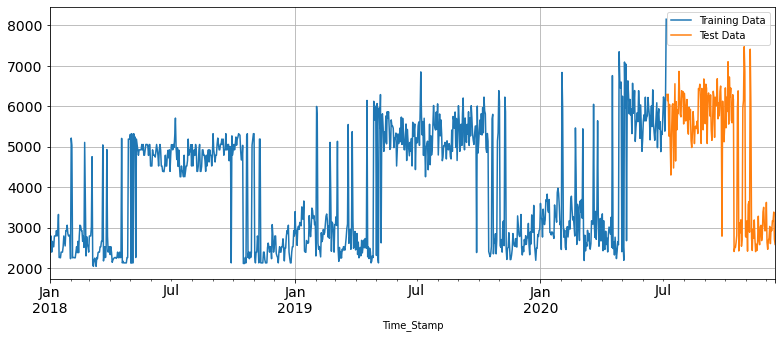

<IPython.core.display.Javascript object>

In [33]:
# Plotting train and test together
train["Sales"].plot(figsize=(13, 5), fontsize=14)
test["Sales"].plot(figsize=(13, 5), fontsize=14)
plt.grid()
plt.legend(["Training Data", "Test Data"])
plt.show()

# Building different models and comparing the accuracy metrics.

**I will build about 3 models and choose the best as the final model**
1. Triple Exponential Smoothing (Holt - Winter's Model)
2. SARIMA Model
3. Prophet Model

## Model 1: Triple Exponential Smoothing (Holt - Winter's Model)

In [34]:
TES_train = train.copy()
TES_test = test.copy()

<IPython.core.display.Javascript object>

In [35]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

model_TES = ExponentialSmoothing(
    TES_train["Sales"], trend="additive", seasonal="multiplicative", freq="D"
)

<IPython.core.display.Javascript object>

In [36]:
model_TES_autofit = model_TES.fit()

C:\Users\dell\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



<IPython.core.display.Javascript object>

In [37]:
model_TES_autofit.params

{'smoothing_level': 0.2525,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.029900000000000003,
 'damping_trend': nan,
 'initial_level': 3973.7374812272724,
 'initial_trend': 36.291628571428575,
 'initial_seasons': array([0.7363345 , 0.67632324, 0.70286475, 0.6024555 , 0.669395  ,
        0.63592525, 0.63592525]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

<IPython.core.display.Javascript object>

In [38]:
## Prediction on the test data

TES_test["auto_predict"] = model_TES_autofit.forecast(steps=len(test))
TES_test.head()

Sales  auto_predict
Time_Stamp                           
2020-07-07  6289.378480   6629.665568
2020-07-08  6136.641280   6613.537529
2020-07-09  6295.347520   6532.605090
2020-07-10  5261.579431   6386.247309
2020-07-11  6043.911286   6438.991490

<IPython.core.display.Javascript object>

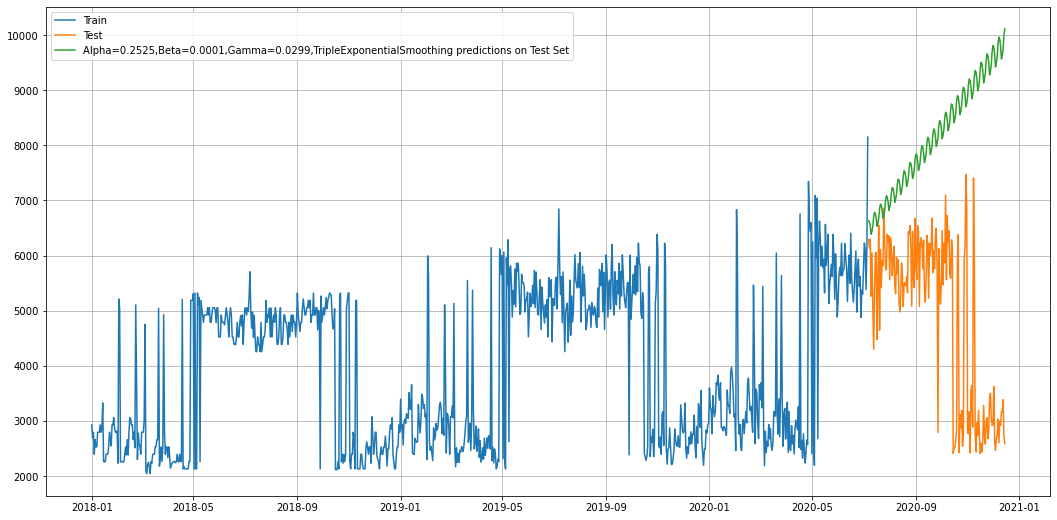

<IPython.core.display.Javascript object>

In [39]:
## Plotting on both the Training and Test using autofit

plt.figure(figsize=(18, 9))
plt.plot(TES_train["Sales"], label="Train")
plt.plot(TES_test["Sales"], label="Test")

plt.plot(
    TES_test["auto_predict"],
    label="Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExponentialSmoothing predictions on Test Set",
)


plt.legend(loc="best")
plt.grid()

### Model Evaluation

In [40]:
## RMSE of predicted data

rmse_model6_test_1 = metrics.mean_squared_error(
    TES_test["Sales"], TES_test["auto_predict"], squared=False
)
print(
    "For Alpha=0.2525,Beta=0.0001,Gamma=0.0299,Triple Exponential Smoothing model Forecast on Test Set,  RMSE is %3.3f"
    % (rmse_model6_test_1)
)

For Alpha=0.2525,Beta=0.0001,Gamma=0.0299,Triple Exponential Smoothing model Forecast on Test Set,  RMSE is 4047.704


<IPython.core.display.Javascript object>

In [41]:
resultsDf = pd.DataFrame(
    {"Test RMSE": [rmse_model6_test_1]},
    index=["Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExponentialSmoothing"],
)

resultsDf

Test RMSE
Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExp...  4047.70421

<IPython.core.display.Javascript object>

### Training Triple Exponential Smoothing models with different pdq and PDQ parameters

In [42]:
## First we will define an empty dataframe to store our values from the loop

resultsDf_0 = pd.DataFrame(
    {
        "Alpha Values": [],
        "Beta Values": [],
        "Gamma Values": [],
        "Train RMSE": [],
        "Test RMSE": [],
    }
)
resultsDf_0

Empty DataFrame
Columns: [Alpha Values, Beta Values, Gamma Values, Train RMSE, Test RMSE]
Index: []

<IPython.core.display.Javascript object>

In [43]:
for i in np.arange(0.3, 1.1, 0.1):
    for j in np.arange(0.3, 1.1, 0.1):
        for k in np.arange(0.3, 1.1, 0.1):
            model_TES_alpha_i_j_k = model_TES.fit(
                smoothing_level=i,
                smoothing_trend=j,
                smoothing_seasonal=k,
                optimized=False,
                use_brute=True,
            )
            TES_train["predict", i, j, k] = model_TES_alpha_i_j_k.fittedvalues
            TES_test["predict", i, j, k] = model_TES_alpha_i_j_k.forecast(steps=162)

            rmse_model8_train = metrics.mean_squared_error(
                TES_train["Sales"], TES_train["predict", i, j, k], squared=False
            )

            rmse_model8_test = metrics.mean_squared_error(
                TES_test["Sales"], TES_test["predict", i, j, k], squared=False
            )

            resultsDf_0 = resultsDf_0.append(
                {
                    "Alpha Values": i,
                    "Beta Values": j,
                    "Gamma Values": k,
                    "Train RMSE": rmse_model8_train,
                    "Test RMSE": rmse_model8_test,
                },
                ignore_index=True,
            )
            # Finding the column name with the minimum RMSE
            if rmse_model8_test == resultsDf_0["Test RMSE"].min():
                print(TES_test["predict", i, j, k].name)

('predict', 0.3, 0.3, 0.3)
('predict', 0.3, 0.3, 0.4)
('predict', 0.3, 1.0000000000000002, 0.8000000000000003)
('predict', 0.8000000000000003, 0.8000000000000003, 0.8000000000000003)


<IPython.core.display.Javascript object>

In [44]:
resultsDf_0

Alpha Values  Beta Values  Gamma Values    Train RMSE     Test RMSE
0             0.3          0.3           0.3  1.159031e+03  3.005640e+04
1             0.3          0.3           0.4  1.240951e+03  2.967817e+04
2             0.3          0.3           0.5  1.330114e+03  2.993230e+04
3             0.3          0.3           0.6  1.434564e+03  3.107504e+04
4             0.3          0.3           0.7  1.572483e+03  3.278951e+04
..            ...          ...           ...           ...           ...
507           1.0          1.0           0.6  1.862261e+05  4.261929e+06
508           1.0          1.0           0.7  3.472177e+05  1.015383e+06
509           1.0          1.0           0.8  1.106757e+06  3.120688e+06
510           1.0          1.0           0.9  1.434780e+06  6.892968e+09
511           1.0          1.0           1.0  7.940079e+04  1.112074e+06

[512 rows x 5 columns]

<IPython.core.display.Javascript object>

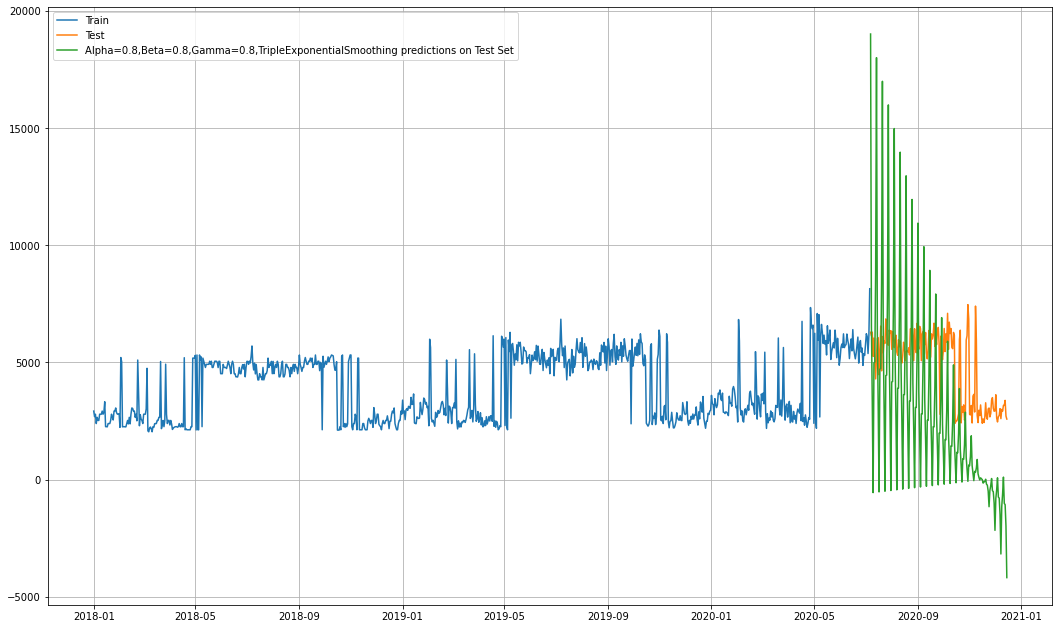

<IPython.core.display.Javascript object>

In [45]:
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(18, 11))
plt.plot(TES_train["Sales"], label="Train")
plt.plot(TES_test["Sales"], label="Test")

# The value of alpha and beta is taken like that by python
plt.plot(
    TES_test["predict", 0.8000000000000003, 0.8000000000000003, 0.8000000000000003],
    label="Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialSmoothing predictions on Test Set",
)


plt.legend(loc="best")
plt.grid()

In [46]:
# ADDING THE RMSE TO THE RESULT DATAFRAME
resultsDf_01 = pd.DataFrame(
    {"Test RMSE": [resultsDf_0.sort_values(by=["Test RMSE"]).values[0][4]]},
    index=["Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialSmoothing"],
)

resultsDf = pd.concat([resultsDf, resultsDf_01])
resultsDf

Test RMSE
Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExp...  4047.704210
Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialS...  4157.502946

<IPython.core.display.Javascript object>

## Model 2: SARIMA MODEL

### Seasonal Decomposition

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

<IPython.core.display.Javascript object>

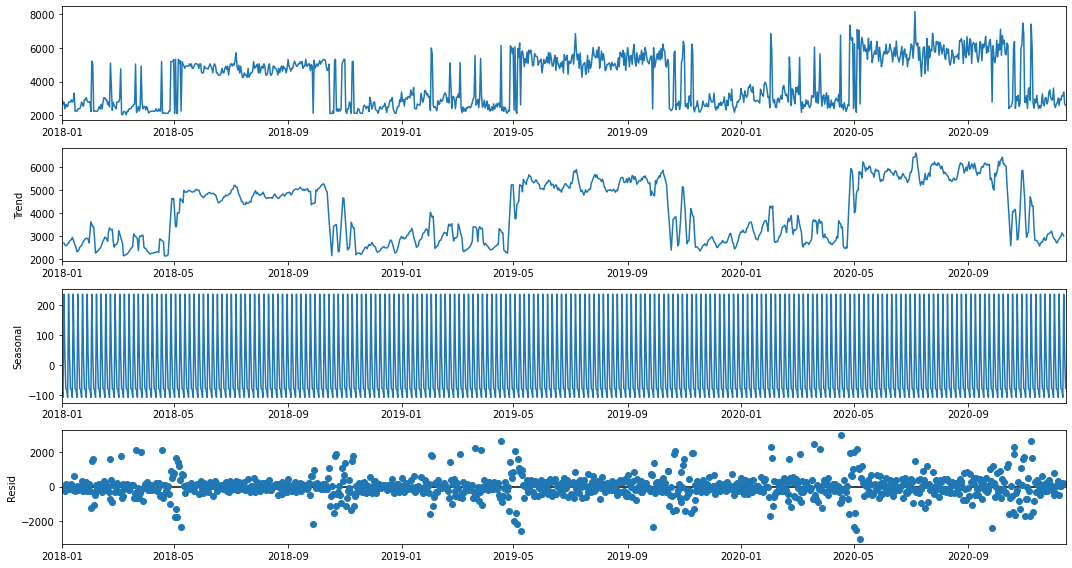

<IPython.core.display.Javascript object>

In [48]:
decomposition = seasonal_decompose(df_sales, model="additive", freq=5)
decomposition.plot()
plt.show()

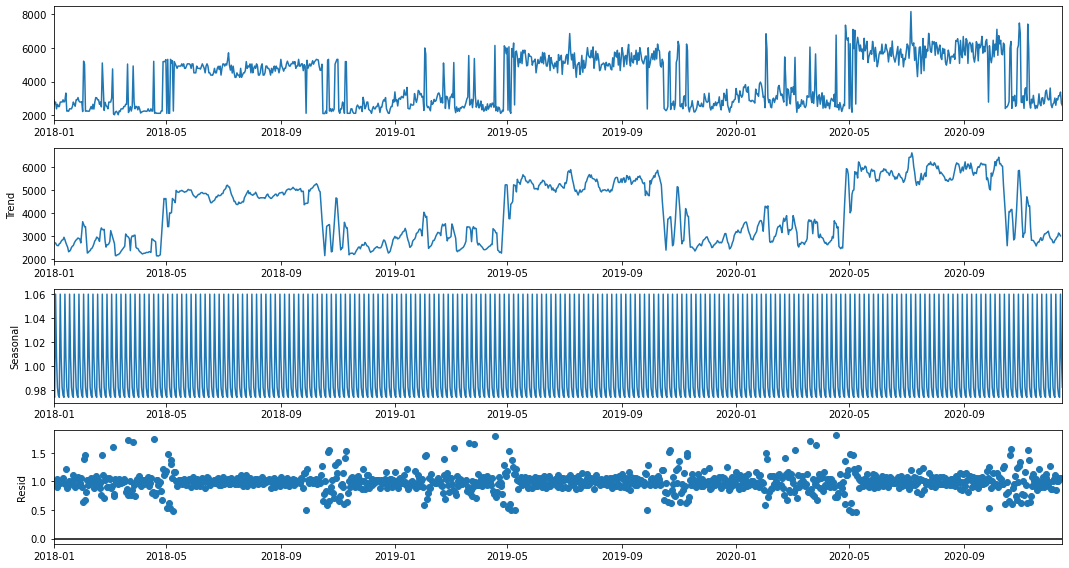

<IPython.core.display.Javascript object>

In [49]:
decomposition = seasonal_decompose(df_sales, model="multiplicative", freq=5)
decomposition.plot()
plt.show()

In [50]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print("Trend", "\n", trend.head(12), "\n")
print("Seasonality", "\n", seasonality.head(12), "\n")
print("Residual", "\n", residual.head(12), "\n")

Trend 
 Time_Stamp
2018-01-01           NaN
2018-01-02           NaN
2018-01-03    2692.10620
2018-01-04    2612.30620
2018-01-05    2580.20000
2018-01-06    2580.20000
2018-01-07    2660.00000
2018-01-08    2686.60000
2018-01-09    2766.40000
2018-01-10    2819.60000
2018-01-11    2834.96416
2018-01-12    2941.36416
Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
2018-01-01    0.975732
2018-01-02    0.974092
2018-01-03    1.059999
2018-01-04    1.007790
2018-01-05    0.982388
2018-01-06    0.975732
2018-01-07    0.974092
2018-01-08    1.059999
2018-01-09    1.007790
2018-01-10    0.982388
2018-01-11    0.975732
2018-01-12    0.974092
Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
2018-01-01         NaN
2018-01-02         NaN
2018-01-03    0.978754
2018-01-04    0.909348
2018-01-05    1.049410
2018-01-06    1.003741
2018-01-07    0.975267
2018-01-08    0.980760
2018-01-09    1.001811
2018-01-10    1.008325
2018-01-11    1.057783
2018-01-12    0.974815
Name: resid, dtype:

<IPython.core.display.Javascript object>

### Checking for stationarity of the series at α = 0.05 using Dickey Fuller tests.

In [51]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller


def test_stationarity(timeseries):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput, "\n")

<IPython.core.display.Javascript object>

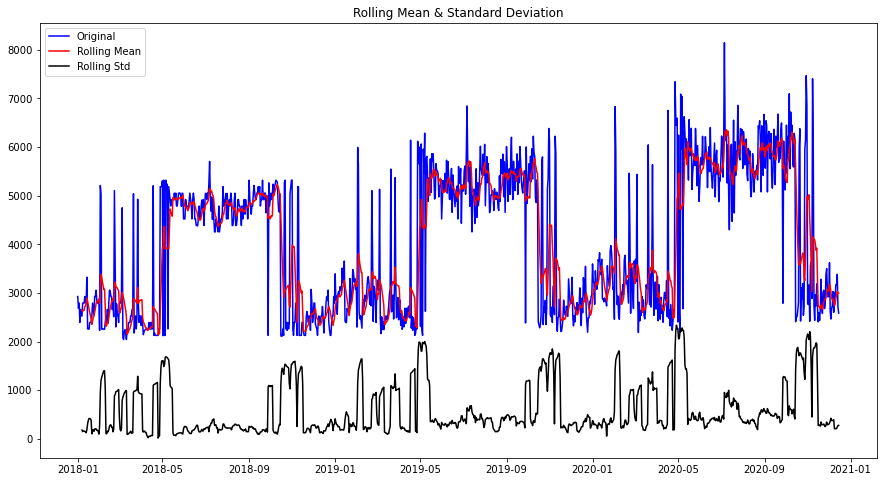

Results of Dickey-Fuller Test:
Test Statistic                   -2.212479
p-value                           0.201748
#Lags Used                       22.000000
Number of Observations Used    1057.000000
Critical Value (1%)              -3.436552
Critical Value (5%)              -2.864278
Critical Value (10%)             -2.568228
dtype: float64 



<IPython.core.display.Javascript object>

In [52]:
test_stationarity(df_sales["Sales"])

- the p-value = 0.201748, emplying that the data is not stationary hence there is need for diffrenciation

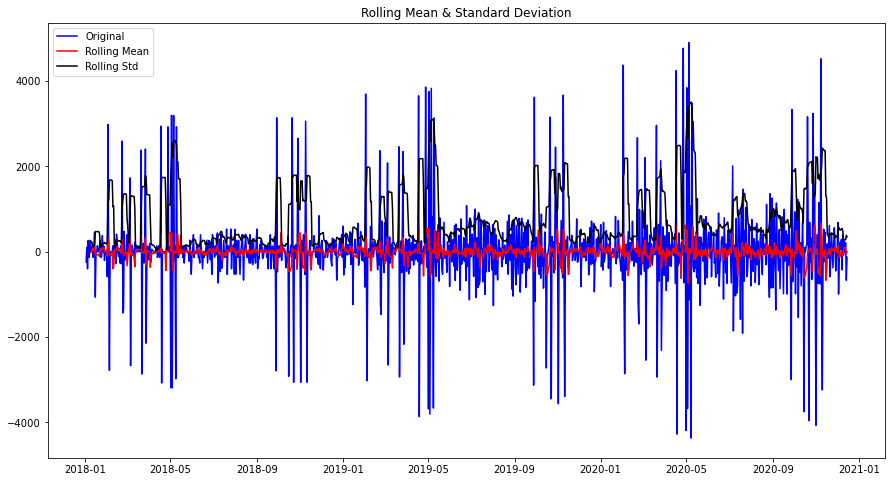

Results of Dickey-Fuller Test:
Test Statistic                -9.498547e+00
p-value                        3.495240e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.057000e+03
Critical Value (1%)           -3.436552e+00
Critical Value (5%)           -2.864278e+00
Critical Value (10%)          -2.568228e+00
dtype: float64 



<IPython.core.display.Javascript object>

In [53]:
test_stationarity(df_sales["Sales"].diff().dropna())

- Now the p-value is less than  α after diffrenciation
- The series is now stationary

### Plotting the Autocorrelation and the Partial Autocorrelation function plots on the whole data.

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<IPython.core.display.Javascript object>

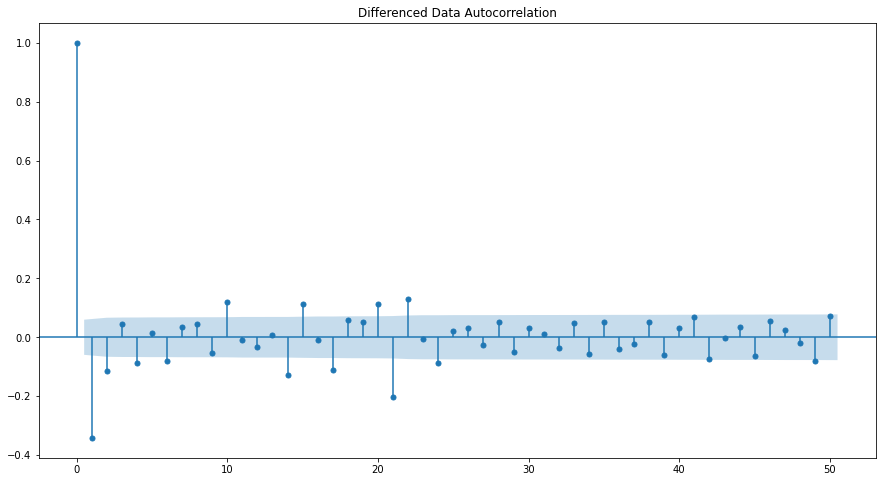

<IPython.core.display.Javascript object>

In [55]:
# Plotting ACF
plot_acf(
    df_sales["Sales"].diff().dropna(), lags=50, title="Differenced Data Autocorrelation"
)
plt.show()

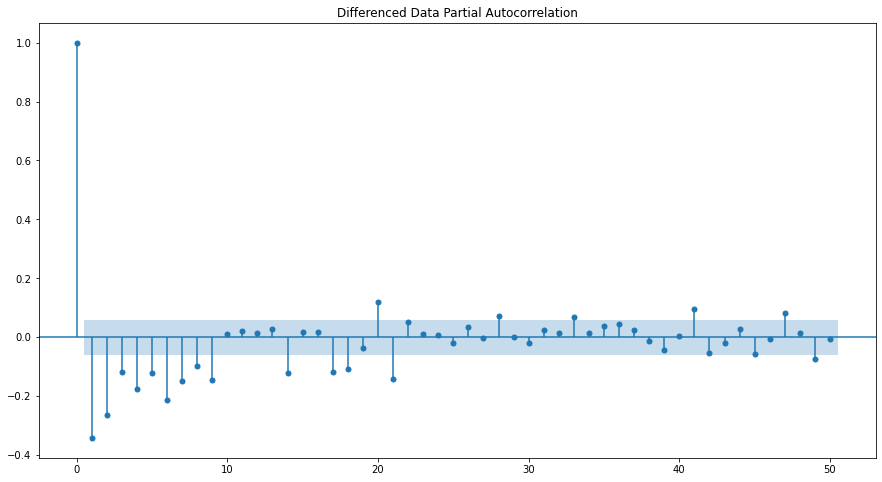

<IPython.core.display.Javascript object>

In [56]:
# Plotting the PACF
plot_pacf(
    df_sales["Sales"].diff().dropna(),
    lags=50,
    title="Differenced Data Partial Autocorrelation",
)
plt.show()

In [57]:
# Defining the pdq and (PDQ)S for the SARIMA model

import itertools

p = q = range(0, 3)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
print("Examples of parameter combinations for Model...")
print("Model: {}{}".format(pdq[1], model_pdq[1]))
print("Model: {}{}".format(pdq[1], model_pdq[2]))
print("Model: {}{}".format(pdq[2], model_pdq[3]))
print("Model: {}{}".format(pdq[2], model_pdq[4]))

Examples of parameter combinations for Model...
Model: (0, 0, 1)(0, 0, 1, 5)
Model: (0, 0, 1)(0, 0, 2, 5)
Model: (0, 0, 2)(0, 1, 0, 5)
Model: (0, 0, 2)(0, 1, 1, 5)


<IPython.core.display.Javascript object>

In [58]:
# Creating an empty Dataframe with column names only to contain the AIC details
SARIMA_AIC = pd.DataFrame(columns=["param", "seasonal", "AIC"])
SARIMA_AIC

Empty DataFrame
Columns: [param, seasonal, AIC]
Index: []

<IPython.core.display.Javascript object>

### Building The SARIMA model

In [59]:
SARIMA_train = train.copy()
SARIMA_test = test.copy()

<IPython.core.display.Javascript object>

In [60]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [61]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(
            SARIMA_train["Sales"],
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        results_SARIMA = SARIMA_model.fit()
        # print("SARIMA{}x{} - AIC:{}".format(param, param_seasonal, results_SARIMA.aic))
        SARIMA_AIC = SARIMA_AIC.append(
            {"param": param, "seasonal": param_seasonal, "AIC": results_SARIMA.aic},
            ignore_index=True,
        )

<IPython.core.display.Javascript object>

In [62]:
SARIMA_AIC.sort_values(by=["AIC"]).head()

param      seasonal           AIC
101  (0, 1, 2)  (1, 1, 2, 5)  14644.272373
209  (1, 1, 2)  (1, 1, 2, 5)  14645.524399
107  (0, 1, 2)  (2, 1, 2, 5)  14645.993658
95   (0, 1, 2)  (0, 1, 2, 5)  14653.161409
203  (1, 1, 2)  (0, 1, 2, 5)  14653.472919

<IPython.core.display.Javascript object>

In [63]:
# Rebulding the model the the best pdq parameter

auto_SARIMA = sm.tsa.statespace.SARIMAX(
    SARIMA_train["Sales"].values,
    order=(0, 1, 2),
    seasonal_order=(1, 1, 2, 5),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results_auto_SARIMA = auto_SARIMA.fit(maxiter=1000)
print(results_auto_SARIMA.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  918
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 5)   Log Likelihood               -7316.136
Date:                           Sun, 27 Nov 2022   AIC                          14644.272
Time:                                   22:08:20   BIC                          14673.080
Sample:                                        0   HQIC                         14655.278
                                           - 918                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6197      0.020    -31.481      0.000      -0.658      -0.581
ma.L2         -0.1763      0.022     -8.190

<IPython.core.display.Javascript object>

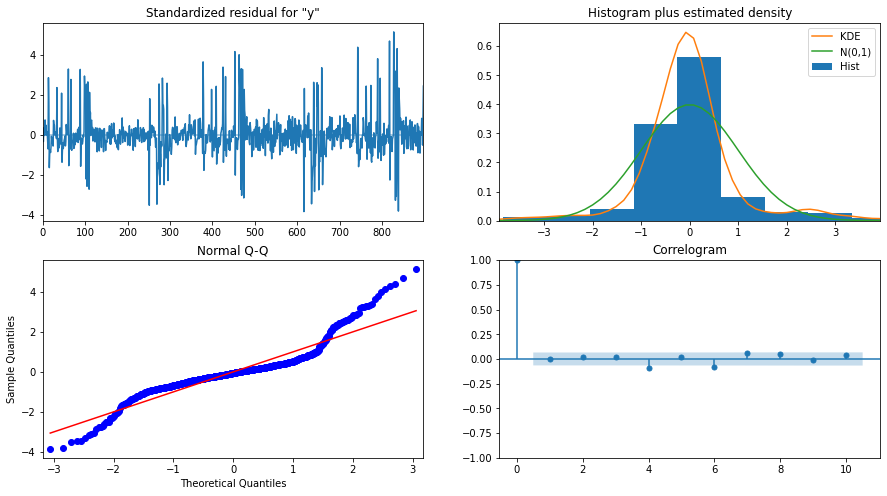

<IPython.core.display.Javascript object>

In [64]:
results_auto_SARIMA.plot_diagnostics()
plt.show()

#### Predict on the Test Set using this model and evaluate the model.

In [65]:
predicted_auto_SARIMA = results_auto_SARIMA.get_forecast(steps=len(test))

<IPython.core.display.Javascript object>

In [66]:
predicted_auto_SARIMA.summary_frame(alpha=0.05).head()

y         mean     mean_se  mean_ci_lower  mean_ci_upper
0  6522.223145  820.952308    4913.186189    8131.260101
1  6092.499245  878.328602    4371.006819    7813.991671
2  6155.439514  894.161890    4402.914413    7907.964615
3  6000.920921  909.721816    4217.898926    7783.942915
4  6277.858680  925.021849    4464.849172    8090.868188

<IPython.core.display.Javascript object>

In [67]:
# Evaluating the model
rmse = metrics.mean_squared_error(
    SARIMA_test["Sales"], predicted_auto_SARIMA.predicted_mean, squared=False
)
print(rmse)

2323.041903514021


<IPython.core.display.Javascript object>

In [68]:
sarima_resultsDf = pd.DataFrame({"Test RMSE": [rmse]}, index=["SARIMA(0,1,2)(1,1,2)5"])

resultsDf = pd.concat([resultsDf, sarima_resultsDf])
resultsDf

Test RMSE
Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExp...  4047.704210
Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialS...  4157.502946
SARIMA(0,1,2)(1,1,2)5                               2323.041904

<IPython.core.display.Javascript object>

In [69]:
SARIMA_test["Predicted"] = predicted_auto_SARIMA.predicted_mean

<IPython.core.display.Javascript object>

In [70]:
SARIMA_test.head()

Sales    Predicted
Time_Stamp                          
2020-07-07  6289.378480  6522.223145
2020-07-08  6136.641280  6092.499245
2020-07-09  6295.347520  6155.439514
2020-07-10  5261.579431  6000.920921
2020-07-11  6043.911286  6277.858680

<IPython.core.display.Javascript object>

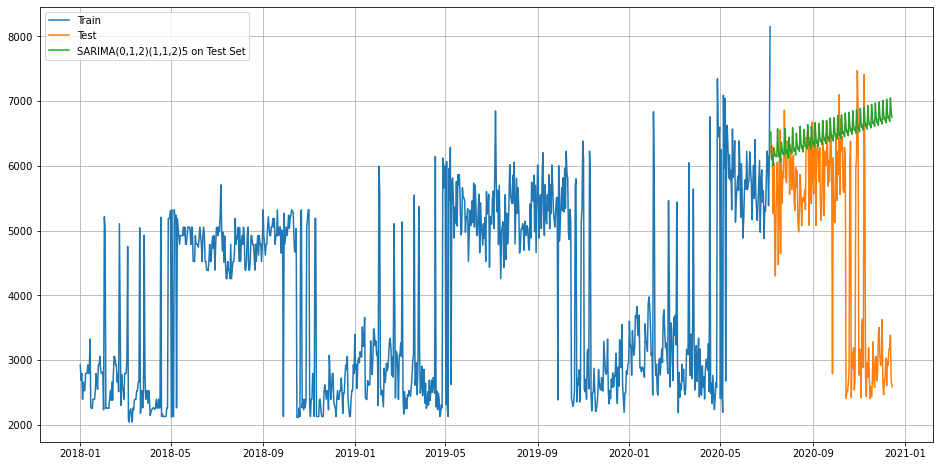

<IPython.core.display.Javascript object>

In [71]:
# Visualizing the SARIMA prediction
## Plotting on both the Training and Test data using brute force alpha, beta and gamma determination

plt.figure(figsize=(16, 8))
plt.plot(SARIMA_train["Sales"], label="Train")
plt.plot(SARIMA_test["Sales"], label="Test")

# The value of alpha and beta is taken like that by python
plt.plot(
    SARIMA_test["Predicted"], label="SARIMA(0,1,2)(1,1,2)5 on Test Set",
)


plt.legend(loc="best")
plt.grid()

## MODEL 3: FBPROPHET MODEL

### Train Model

In [72]:
PROPHET_train = train.copy()
PROPHET_test = test.copy()

<IPython.core.display.Javascript object>

In [73]:
# getting the train and test dataset ready for modelling with prophet
PROPHET_train.reset_index(inplace=True)
PROPHET_train.rename(columns={"Time_Stamp": "ds", "Sales": "y"}, inplace=True)

<IPython.core.display.Javascript object>

In [74]:
PROPHET_test.reset_index(inplace=True)
PROPHET_test.rename(columns={"Time_Stamp": "ds", "Sales": "y"}, inplace=True)

<IPython.core.display.Javascript object>

In [75]:
PROPHET_train.head()

ds         y
0 2018-01-01  2926.000
1 2018-01-02  2687.531
2 2018-01-03  2793.000
3 2018-01-04  2394.000
4 2018-01-05  2660.000

<IPython.core.display.Javascript object>

In [76]:
prophet = Prophet(interval_width=0.95, daily_seasonality=True)
model = prophet.fit(PROPHET_train)

22:08:22 - cmdstanpy - INFO - Chain [1] start processing
22:08:22 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

## Forecasting

In [77]:
future = prophet.make_future_dataframe(periods=len(PROPHET_test), freq="D")
forecast = prophet.predict(future)
forecast.head()

ds        trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2018-01-01  3035.033001  977.376377  3968.582509  3035.033001  3035.033001   
1 2018-01-02  3036.015021  836.947018  4015.646992  3036.015021  3036.015021   
2 2018-01-03  3036.997042  855.829704  3925.537376  3036.997042  3036.997042   
3 2018-01-04  3037.979062  960.377708  4092.968902  3037.979062  3037.979062   
4 2018-01-05  3038.961082  945.098926  3910.642304  3038.961082  3038.961082   

   additive_terms  additive_terms_lower  additive_terms_upper      daily  ...  \
0     -588.455134           -588.455134           -588.455134  449.16533  ...   
1     -616.735125           -616.735125           -616.735125  449.16533  ...   
2     -616.307815           -616.307815           -616.307815  449.16533  ...   
3     -600.718189           -600.718189           -600.718189  449.16533  ...   
4     -647.087297           -647.087297           -647.087297  449.16533  ...   

      weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0  71.124845     71.124845     71.124845 -1108.745309  -1108.745309   
1  21.632822     21.632822     21.632822 -1087.533276  -1087.533276   
2  -0.096360     -0.096360     -0.096360 -1065.376785  -1065.376785   
3  -7.409391     -7.409391     -7.409391 -1042.474128  -1042.474128   
4 -77.192440    -77.192440    -77.192440 -1019.060187  -1019.060187   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  -1108.745309                   0.0                         0.0   
1  -1087.533276                   0.0                         0.0   
2  -1065.376785                   0.0                         0.0   
3  -1042.474128                   0.0                         0.0   
4  -1019.060187                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2446.577867  
1                         0.0  2419.279896  
2                         0.0  2420.689226  
3                         0.0  2437.260872  
4                         0.0  2391.873785  

[5 rows x 22 columns]

<IPython.core.display.Javascript object>

In [78]:
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
1075 2020-12-11  4094.393100  1665.738362  4630.230612  4094.291536   
1076 2020-12-12  4095.379500  1605.161346  4771.547322  4095.277086   
1077 2020-12-13  4096.365901  1748.937269  4771.846162  4096.262635   
1078 2020-12-14  4097.352301  1751.296184  4853.000146  4097.248184   
1079 2020-12-15  4098.338701  1682.018415  4825.942590  4098.233733   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1075  4094.495678    -1016.526698          -1016.526698          -1016.526698   
1076  4095.482934     -952.053232           -952.053232           -952.053232   
1077  4096.470131     -890.360677           -890.360677           -890.360677   
1078  4097.457329     -825.072021           -825.072021           -825.072021   
1079  4098.444527     -861.492249           -861.492249           -861.492249   

          daily  ...     weekly  weekly_lower  weekly_upper       yearly  \
1075  449.16533  ... -77.192440    -77.192440    -77.192440 -1388.499588   
1076  449.16533  ... -27.667958    -27.667958    -27.667958 -1373.550604   
1077  449.16533  ...  19.608482     19.608482     19.608482 -1359.134489   
1078  449.16533  ...  71.124845     71.124845     71.124845 -1345.362196   
1079  449.16533  ...  21.632822     21.632822     21.632822 -1332.290400   

      yearly_lower  yearly_upper  multiplicative_terms  \
1075  -1388.499588  -1388.499588                   0.0   
1076  -1373.550604  -1373.550604                   0.0   
1077  -1359.134489  -1359.134489                   0.0   
1078  -1345.362196  -1345.362196                   0.0   
1079  -1332.290400  -1332.290400                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper         yhat  
1075                         0.0                         0.0  3077.866402  
1076                         0.0                         0.0  3143.326268  
1077                         0.0                         0.0  3206.005223  
1078                         0.0                         0.0  3272.280279  
1079                         0.0                         0.0  3236.846452  

[5 rows x 22 columns]

<IPython.core.display.Javascript object>

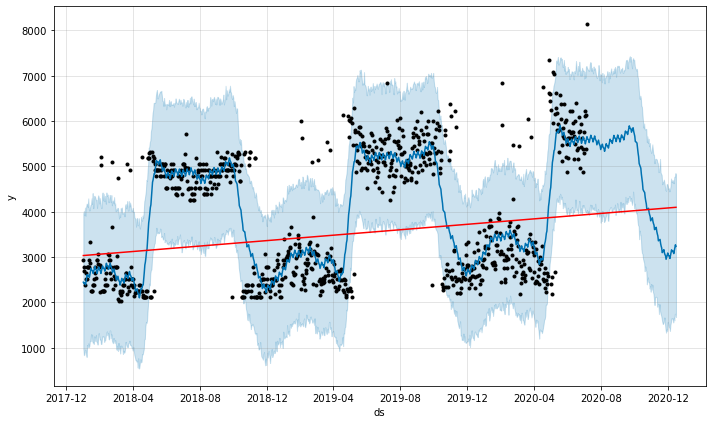

<IPython.core.display.Javascript object>

In [79]:
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

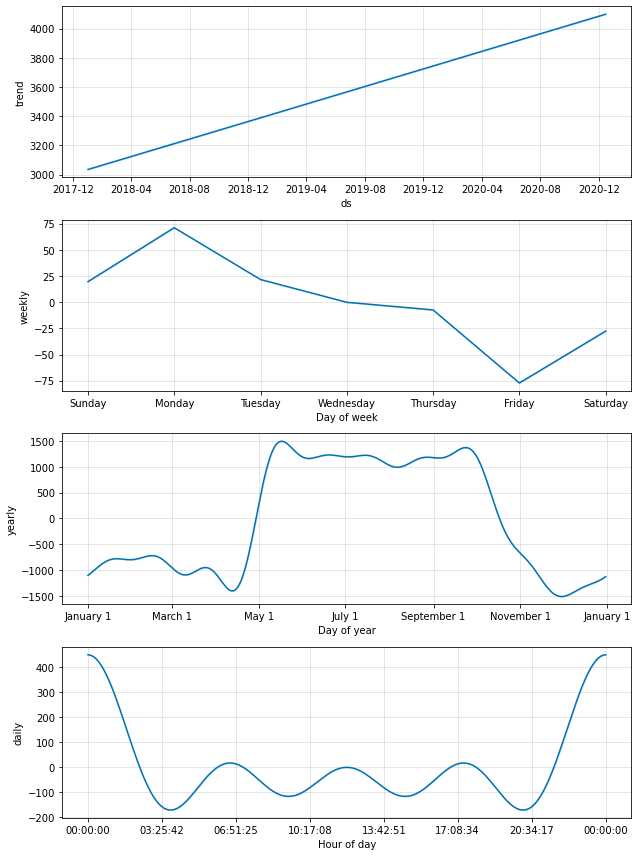

<IPython.core.display.Javascript object>

In [80]:
plt2 = prophet.plot_components(forecast)

In [81]:
PROPHET_test["yhat"] = forecast.tail(len(PROPHET_test))["yhat"].values.tolist()

<IPython.core.display.Javascript object>

In [82]:
PROPHET_test.head()

ds            y         yhat
0 2020-07-07  6289.378480  5609.719165
1 2020-07-08  6136.641280  5592.835087
2 2020-07-09  6295.347520  5590.622026
3 2020-07-10  5261.579431  5525.942592
4 2020-07-11  6043.911286  5580.306631

<IPython.core.display.Javascript object>

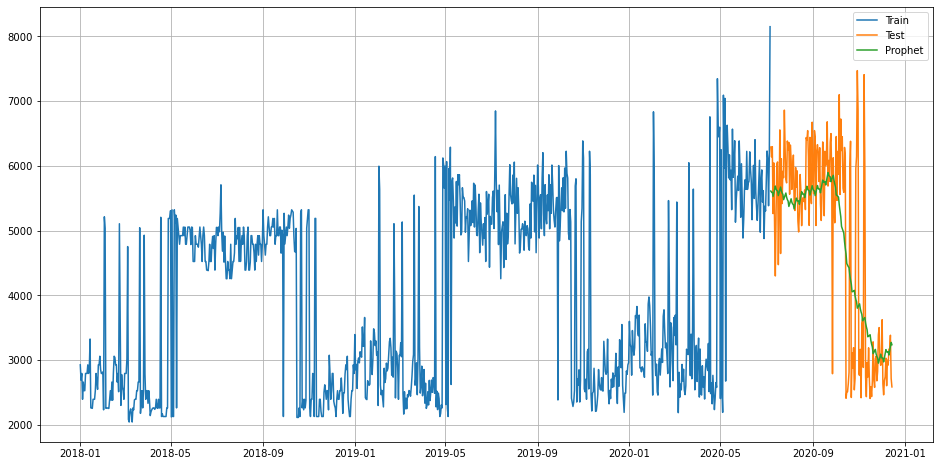

<IPython.core.display.Javascript object>

In [83]:
plt.figure(figsize=(16, 8))
plt.plot(train["Sales"], label="Train")
plt.plot(test["Sales"], label="Test")

plt.plot(
    PROPHET_test["ds"], PROPHET_test["yhat"], label="Prophet",
)


plt.legend(loc="best")
plt.grid()

- From the visualisation, the prophet model seems to have performed better than other models

In [84]:
rmse = metrics.mean_squared_error(
    PROPHET_test["y"], forecast.tail(len(PROPHET_test))["yhat"], squared=False
)
print(rmse)

972.8635023338716


<IPython.core.display.Javascript object>

In [85]:
resultsDf_prophet = pd.DataFrame({"Test RMSE": rmse}, index=["Prophet"])

resultsDf = pd.concat([resultsDf, resultsDf_prophet])
resultsDf

Test RMSE
Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExp...  4047.704210
Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialS...  4157.502946
SARIMA(0,1,2)(1,1,2)5                               2323.041904
Prophet                                              972.863502

<IPython.core.display.Javascript object>

### Prophet Model (Adjusting trend by changepoint_prior_scale)

In [86]:
prophet = Prophet(
    changepoint_prior_scale=0.08, interval_width=0.95, daily_seasonality=True
)
model = prophet.fit(PROPHET_train)

22:08:39 - cmdstanpy - INFO - Chain [1] start processing
22:08:40 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

In [87]:
future = prophet.make_future_dataframe(periods=len(PROPHET_test), freq="D")
forecast = prophet.predict(future)
forecast.head()

ds        trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2018-01-01  3035.847775  938.590397  3930.582437  3035.847775  3035.847775   
1 2018-01-02  3036.755506  886.176404  3931.398601  3036.755506  3036.755506   
2 2018-01-03  3037.663237  968.073657  3911.186889  3037.663237  3037.663237   
3 2018-01-04  3038.570968  943.688598  3951.386447  3038.570968  3038.570968   
4 2018-01-05  3039.478699  899.276920  3878.382320  3039.478699  3039.478699   

   additive_terms  additive_terms_lower  additive_terms_upper       daily  \
0     -578.625175           -578.625175           -578.625175  459.793241   
1     -606.928324           -606.928324           -606.928324  459.793241   
2     -606.647529           -606.647529           -606.647529  459.793241   
3     -591.195341           -591.195341           -591.195341  459.793241   
4     -637.691640           -637.691640           -637.691640  459.793241   

   ...     weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0  ...  71.045499     71.045499     71.045499 -1109.463915  -1109.463915   
1  ...  21.675413     21.675413     21.675413 -1088.396977  -1088.396977   
2  ...  -0.064310     -0.064310     -0.064310 -1066.376460  -1066.376460   
3  ...  -7.388859     -7.388859     -7.388859 -1043.599723  -1043.599723   
4  ... -77.183942    -77.183942    -77.183942 -1020.300939  -1020.300939   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0  -1109.463915                   0.0                         0.0   
1  -1088.396977                   0.0                         0.0   
2  -1066.376460                   0.0                         0.0   
3  -1043.599723                   0.0                         0.0   
4  -1020.300939                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  2457.222600  
1                         0.0  2429.827183  
2                         0.0  2431.015709  
3                         0.0  2447.375627  
4                         0.0  2401.787059  

[5 rows x 22 columns]

<IPython.core.display.Javascript object>

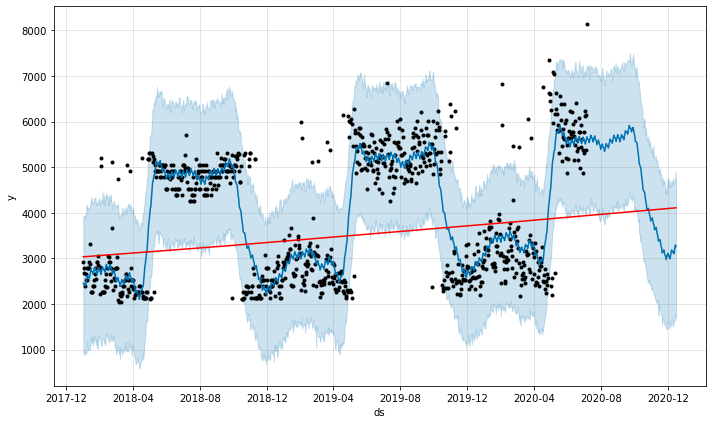

<IPython.core.display.Javascript object>

In [88]:
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

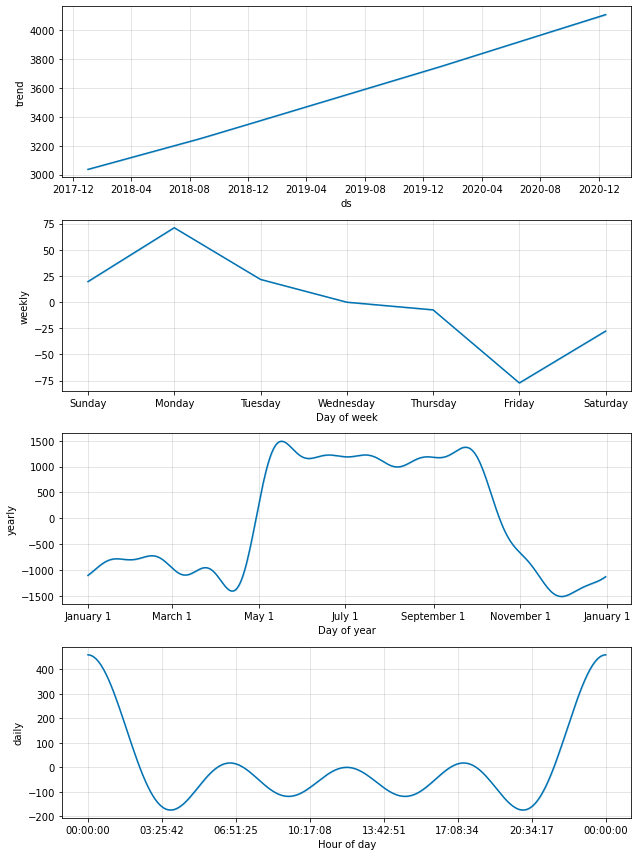

<IPython.core.display.Javascript object>

In [89]:
plt2 = prophet.plot_components(forecast)

In [90]:
PROPHET_test["yhat_adj"] = forecast.tail(len(PROPHET_test))["yhat"].values.tolist()

<IPython.core.display.Javascript object>

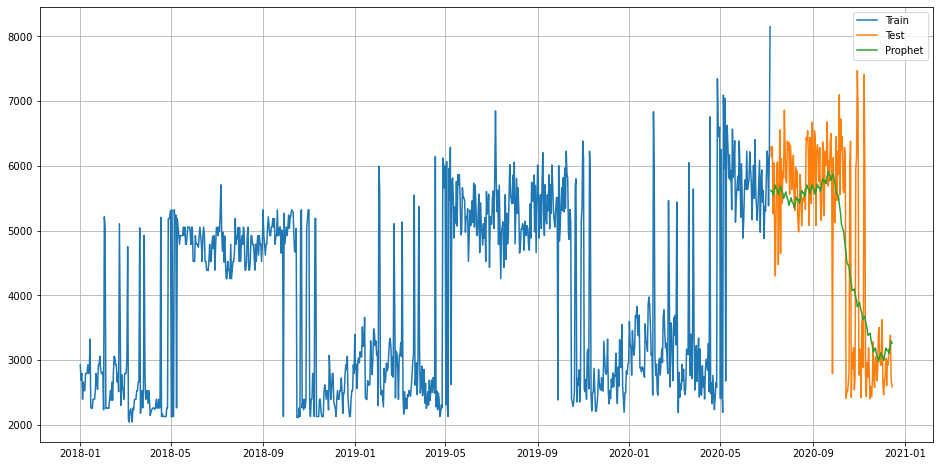

<IPython.core.display.Javascript object>

In [91]:
plt.figure(figsize=(16, 8))
plt.plot(train["Sales"], label="Train")
plt.plot(test["Sales"], label="Test")

plt.plot(
    PROPHET_test["ds"], PROPHET_test["yhat_adj"], label="Prophet",
)


plt.legend(loc="best")
plt.grid()

In [92]:
rmse = metrics.mean_squared_error(
    PROPHET_test["y"], forecast.tail(len(PROPHET_test))["yhat"], squared=False
)
print(rmse)

971.3287867948566


<IPython.core.display.Javascript object>

In [93]:
resultsDf_prophet_adj = pd.DataFrame({"Test RMSE": rmse}, index=["Prophet_adjsuted"])

resultsDf = pd.concat([resultsDf, resultsDf_prophet_adj])
resultsDf

Test RMSE
Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExp...  4047.704210
Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialS...  4157.502946
SARIMA(0,1,2)(1,1,2)5                               2323.041904
Prophet                                              972.863502
Prophet_adjsuted                                     971.328787

<IPython.core.display.Javascript object>

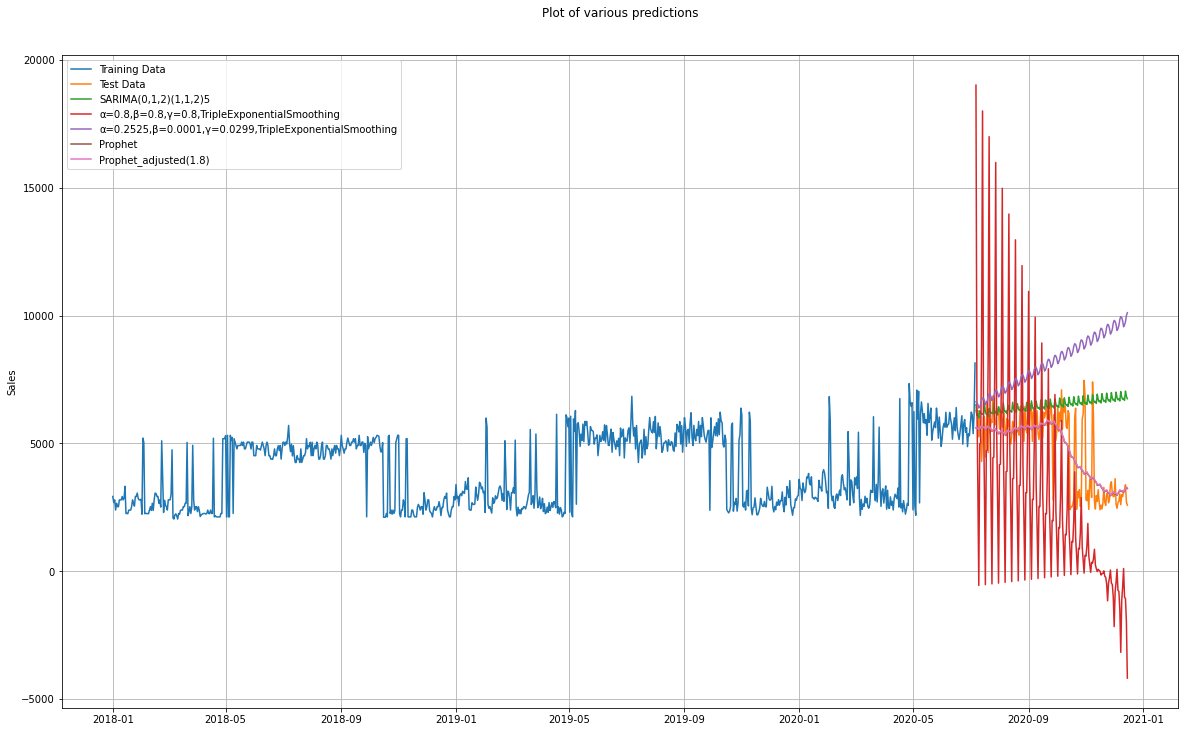

<IPython.core.display.Javascript object>

In [94]:
# Plotting the entire predictions on one plot
plt.figure(figsize=(20, 12))
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(SARIMA_test["Predicted"], label="SARIMA(0,1,2)(1,1,2)5")
plt.plot(
    TES_test["predict", 0.8000000000000003, 0.8000000000000003, 0.8000000000000003],
    label="α=0.8,β=0.8,γ=0.8,TripleExponentialSmoothing",
)
plt.plot(
    TES_test["auto_predict"],
    label="α=0.2525,β=0.0001,γ=0.0299,TripleExponentialSmoothing",
)
plt.plot(
    PROPHET_test["ds"], PROPHET_test["yhat"], label="Prophet",
)
plt.plot(
    PROPHET_test["ds"], PROPHET_test["yhat_adj"], label="Prophet_adjusted(1.8)",
)
plt.title("Plot of various predictions", y=1.05)
plt.ylabel("Sales")
plt.legend(loc='best')
plt.grid();



## Choosing the Final Model based on least RMSE and training it with the entire dataset

In [95]:
## Choosing the Final Model
resultsDf.sort_values(by=["Test RMSE"])

Test RMSE
Prophet_adjsuted                                     971.328787
Prophet                                              972.863502
SARIMA(0,1,2)(1,1,2)5                               2323.041904
Alpha=0.2525,Beta=0.0001,Gamma=0.0299,TripleExp...  4047.704210
Alpha=0.8,Beta=0.8,Gamma=0.8,TripleExponentialS...  4157.502946

<IPython.core.display.Javascript object>

- The best Model is the Prophet Model with Adjusting trend by changepoint_prior_scale

In [96]:
# Making a copy of the earlier entire dataset
df_prophet = df_sales.copy()
# getting the dataset ready for modelling with prophet
df_prophet.reset_index(inplace=True)
df_prophet.rename(columns={"Time_Stamp": "ds", "Sales": "y"}, inplace=True)

<IPython.core.display.Javascript object>

In [97]:
# building the final model with the entire sales data, both train and test data
final_model = Prophet(
    changepoint_prior_scale=0.08, interval_width=0.95, daily_seasonality=True
).fit(df_prophet)

22:08:54 - cmdstanpy - INFO - Chain [1] start processing
22:08:54 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>

In [98]:
future = final_model.make_future_dataframe(periods=len(PROPHET_test), freq="D")
forecast = final_model.predict(future)
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
1237 2021-05-22  4277.508070  4612.960806  7669.007973  4262.585258   
1238 2021-05-23  4278.603752  4666.686825  7794.469074  4263.633858   
1239 2021-05-24  4279.699433  4579.858969  7871.974353  4264.460851   
1240 2021-05-25  4280.795115  4597.369948  7737.002813  4265.375875   
1241 2021-05-26  4281.890796  4579.249276  7757.523408  4266.377831   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1237  4293.373966     1878.940882           1878.940882           1878.940882   
1238  4294.565269     1897.015472           1897.015472           1897.015472   
1239  4295.752615     1896.106303           1896.106303           1896.106303   
1240  4296.903761     1851.427263           1851.427263           1851.427263   
1241  4298.000534     1802.078603           1802.078603           1802.078603   

           daily  ...     weekly  weekly_lower  weekly_upper       yearly  \
1237  505.045787  ... -33.445460    -33.445460    -33.445460  1407.340555   
1238  505.045787  ...  14.054336     14.054336     14.054336  1377.915349   
1239  505.045787  ...  43.916983     43.916983     43.916983  1347.143534   
1240  505.045787  ...  30.311125     30.311125     30.311125  1316.070351   
1241  505.045787  ...  11.376483     11.376483     11.376483  1285.656333   

      yearly_lower  yearly_upper  multiplicative_terms  \
1237   1407.340555   1407.340555                   0.0   
1238   1377.915349   1377.915349                   0.0   
1239   1347.143534   1347.143534                   0.0   
1240   1316.070351   1316.070351                   0.0   
1241   1285.656333   1285.656333                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper         yhat  
1237                         0.0                         0.0  6156.448952  
1238                         0.0                         0.0  6175.619224  
1239                         0.0                         0.0  6175.805736  
1240                         0.0                         0.0  6132.222378  
1241                         0.0                         0.0  6083.969399  

[5 rows x 22 columns]

<IPython.core.display.Javascript object>

In [99]:
df_sales.head()

Sales
Time_Stamp          
2018-01-01  2926.000
2018-01-02  2687.531
2018-01-03  2793.000
2018-01-04  2394.000
2018-01-05  2660.000

<IPython.core.display.Javascript object>

In [100]:
# getting the dataset of only the forecast
# the new forecast has the lenght of our the test data. 162 days into the future
forecast_only = forecast.tail(len(PROPHET_test))

<IPython.core.display.Javascript object>

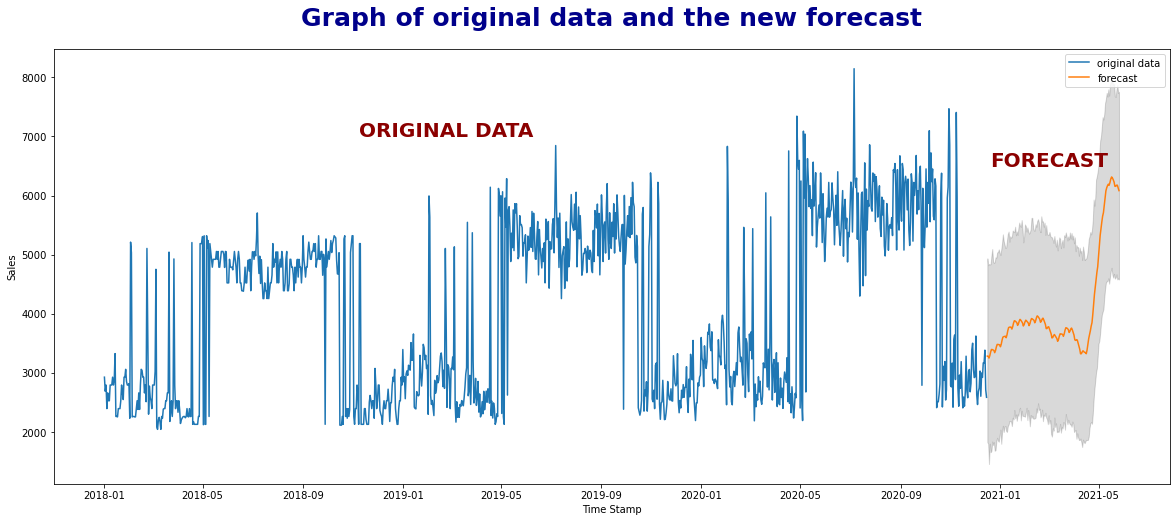

<IPython.core.display.Javascript object>

In [101]:
# VISUALIZATION
plt.figure(figsize=(20, 8))
plt.plot(df_prophet["ds"], df_prophet["y"], label="original data")
plt.plot(forecast_only["ds"], forecast_only["yhat"], label="forecast")

# Plotting the confidence interval
plt.fill_between(
    forecast_only["ds"],
    forecast_only["yhat_lower"],
    forecast_only["yhat_upper"],
    color="k",
    alpha=0.15,
)

plt.title(
    "Graph of original data and the new forecast",
    y=1.04,
    fontdict={"fontsize": 25, "fontweight": "bold", "color": "darkblue"},
)
plt.text(
    dt.date(2018, 11, 9),
    7000,
    "ORIGINAL DATA",
    fontdict={"fontweight": "bold", "color": "darkred", "fontsize": 20},
)
plt.text(
    dt.date(2020, 12, 20),
    6500,
    "FORECAST",
    fontdict={"fontweight": "bold", "color": "darkred", "fontsize": 20},
)
plt.ylabel("Sales")
plt.xlabel("Time Stamp")
plt.legend()
# plt.grid()
plt.show()

## The End!!